<a href="https://colab.research.google.com/github/ritwikraha/CV-Practice/blob/master/sam_with_controlnet_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers -qq
!pip install accelerate -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.0 MB/s eta 0:00:00


In [2]:
import cv2
import torch
import random
import requests
import numpy as np
from PIL import Image
from transformers import pipeline
from matplotlib import pyplot as plt

from diffusers import StableDiffusionXLControlNetInpaintPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image

In [9]:
image_url = "https://i.imgur.com/iWjdvXK.jpg"
pil_image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB").resize((1024, 1024))
np_image = np.array(pil_image)

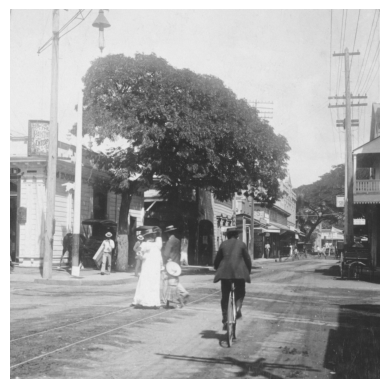

In [10]:
plt.imshow(np_image)
plt.axis("off")
plt.show()

In [14]:
# Constants
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MIN_AREA_THRESHOLD = 0.01

# Initialize models
SAM_GENERATOR = pipeline(
    task="mask-generation",
    model="facebook/sam-vit-large",
    device=DEVICE)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [15]:
def run_sam(image_rgb_pil):
    outputs = SAM_GENERATOR(image_rgb_pil, points_per_batch=64)
    return np.array(outputs['masks'])


def inference(image_rgb_pil):
    width, height = image_rgb_pil.size
    area = width * height

    mask = run_sam(image_rgb_pil)
    # Make sure we get the masks which pass the
    # minimum threshold area
    mask = mask[mask.sum(axis=(1, 2)) / area > MIN_AREA_THRESHOLD]

    filtered_mask = []
    for m in mask:
        masked_image = Image.fromarray(
            (m[..., None] * np.array(image_rgb_pil)).astype(np.uint8)
        )
        filtered_mask.append(m)

    final_mask = np.any(filtered_mask, axis=0)
    return Image.fromarray((final_mask * 255).astype(np.uint8))

In [16]:
result = inference(pil_image)

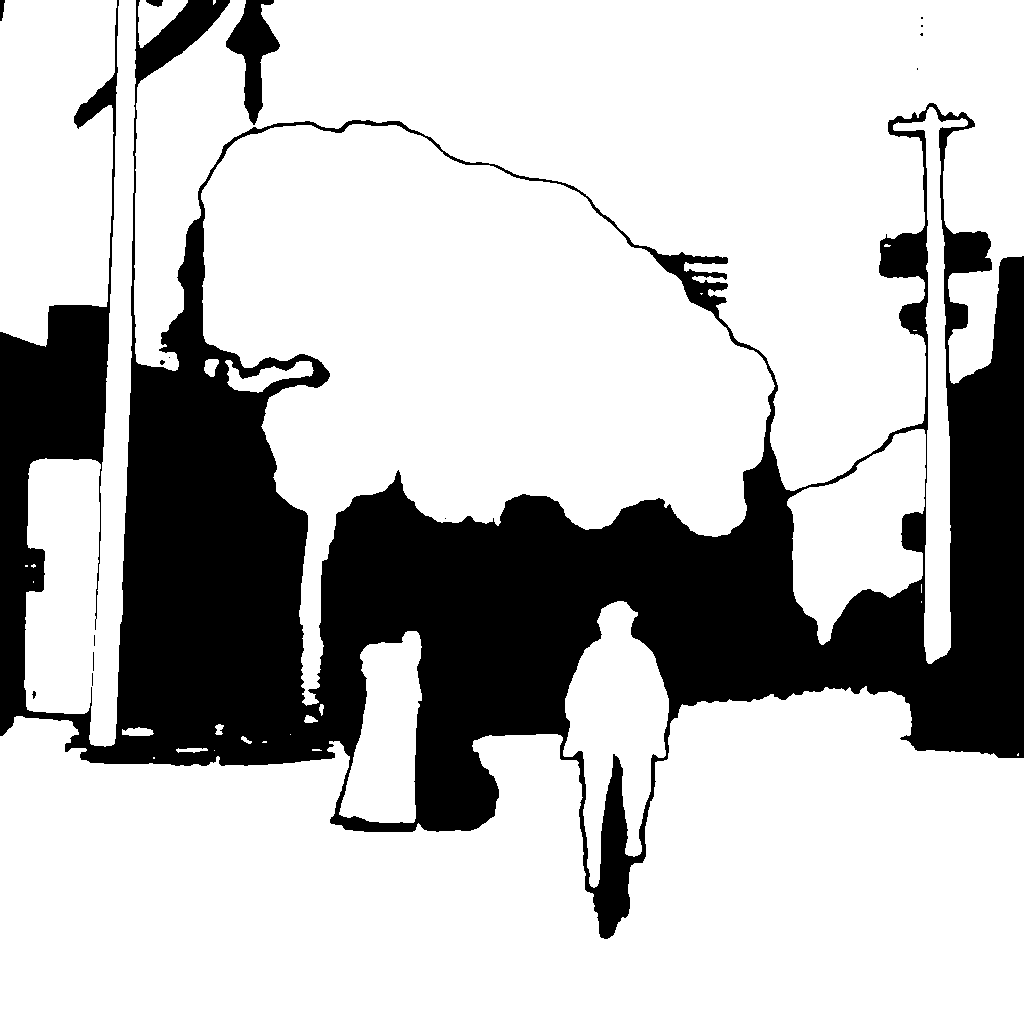

In [18]:
result

In [21]:
init_image = pil_image
# init_image = init_image.resize((1024, 1024))

generator = torch.Generator(device="cpu").manual_seed(1)

mask_image = result
# mask_image = mask_image.resize((1024, 1024))

In [22]:
def make_canny_condition(image):
    image = np.array(image)
    image = cv2.Canny(image, 100, 200)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    image = Image.fromarray(image)
    return image

In [23]:
control_image = make_canny_condition(init_image)

controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0", torch_dtype=torch.float16
)
pipe = StableDiffusionXLControlNetInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.enable_model_cpu_offload()

config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
# generate image
image = pipe(
    "a new kind of reality where the objects are filled with bubbles and candies,vintage, monochrome, highly detailed, film look, grainy",
    num_inference_steps=20,
    generator=generator,
    eta=1.0,
    image=init_image,
    mask_image=mask_image,
    control_image=control_image,
).images[0]

  0%|          | 0/19 [00:00<?, ?it/s]

In [7]:
# def show_masked_segment(image, mask):
#     plt.figure(figsize=(15, 5))

#     plt.subplot(1, 3, 1)
#     plt.imshow(image)
#     plt.axis("off")

#     plt.subplot(1, 3, 2)
#     plt.imshow(mask, cmap="inferno")
#     plt.axis("off")

#     plt.subplot(1, 3, 3)
#     masked_image = np_image * mask[..., None]
#     plt.imshow(masked_image)
#     plt.axis("off")
#     plt.show()

In [ ]:
# for index in range(len(mask_outputs["masks"])):
#     show_masked_segment(image=np_image, mask=mask_outputs["masks"][index])